## XGBoost

In [1]:
#import the libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import re


#import sklearn libraries
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from imblearn.over_sampling import SMOTE, SMOTEN
from sklearn.linear_model import LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE, RFECV
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,roc_auc_score, roc_curve
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel

In [2]:
data = pd.read_csv("data1.csv")

In [3]:
df = pd.read_csv("cleantrain_labels.csv")

## Data Preprocessing

In [4]:
# seperate features from predictor
x = data.drop(["respondent_id","seasonal_vaccine","h1n1_vaccine"], axis=1)
y = data.h1n1_vaccine

In [5]:
data.h1n1_vaccine.value_counts()

,count
h1n1_vaccine,
0,21033
1,5674


In [6]:
#seperate train and test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state=42, stratify=y)

#check shape
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((21365, 35), (5342, 35), (21365,), (5342,))

In [7]:
# do feature scaling
ss = StandardScaler()
x_train_s =ss.fit_transform(x_train)
x_test_s =ss.transform(x_test)

In [8]:
# create xgboost model
boost= XGBClassifier()
boost.fit(x_train_s, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [9]:
# check xgboost score
boost.score(x_train_s, y_train)

0.9131289492160075

In [10]:
# check score accuracy
y_pred = boost.predict(x_test)

acc = accuracy_score(y_test,y_pred)
acc

0.5445526020217147

In [11]:
#check confusion matrix
conf_matrix = confusion_matrix(y_test,y_pred)
conf_matrix

array([[2289, 1918],
       [ 515,  620]])

In [12]:
#classification report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.82      0.54      0.65      4207
           1       0.24      0.55      0.34      1135

    accuracy                           0.54      5342
   macro avg       0.53      0.55      0.50      5342
weighted avg       0.69      0.54      0.59      5342



### Tuned XGB Model H1N1 Vaccine

In [13]:
x1 = df.drop(columns=['respondent_id', 'h1n1_vaccine', 'seasonal_vaccine'])
y_h1n1 = df['h1n1_vaccine']

In [14]:
# Split data - stratify ensures the train/test sets have the same class proportions
X_train, X_test, y_h1n1_train, y_h1n1_test = train_test_split(
    x1, y_h1n1, test_size=0.25, random_state=42, stratify=y_h1n1
)

In [15]:
# Calculate scale_pos_weight for the imbalanced H1N1 data
h1n1_scale_pos_weight = y_h1n1_train.value_counts()[0] / y_h1n1_train.value_counts()[1]
print(f"H1N1 scale_pos_weight: {h1n1_scale_pos_weight:.2f}")

H1N1 scale_pos_weight: 3.71


In [16]:
# Set up the XGBoost Classifier
xgb_h1n1 = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    scale_pos_weight=h1n1_scale_pos_weight, # Crucial for imbalance!
    random_state=42
)

In [17]:
# Define the hyperparameter grid for Randomized Search
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0]
}

# Use Stratified K-Folds for cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [18]:
# Set up RandomizedSearchCV to find the best parameters
random_search_h1n1 = RandomizedSearchCV(
    estimator=xgb_h1n1,
    param_distributions=param_grid,
    n_iter=25,  # Number of parameter settings that are sampled
    scoring='roc_auc', # The best metric for this problem!
    n_jobs=-1,
    cv=cv,
    verbose=1,
    random_state=42
)

# Fit the model
random_search_h1n1.fit(X_train, y_h1n1_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None,
                                           feature_weights=None, gamma=None...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None, ...),
                   n_iter=25, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.7, 0.8, 0.9,
                                                             1.0],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [3, 4, 5, 6],
                                        'n_estimators': [100, 200, 300, 400],
                                        'subsample': [0.7, 0.8, 0.9, 1.0]},
                   random_state=42, scoring='roc_auc', verbose=1)

In [19]:
# Get the best model
best_xgb_h1n1 = random_search_h1n1.best_estimator_
print(f"\nBest H1N1 Model Parameters: {random_search_h1n1.best_params_}")


Best H1N1 Model Parameters: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.8}


In [20]:
# Evaluate the best model on the test set
y_h1n1_pred_proba = best_xgb_h1n1.predict_proba(X_test)[:, 1]
y_h1n1_pred_class = best_xgb_h1n1.predict(X_test)
h1n1_roc_auc = roc_auc_score(y_h1n1_test, y_h1n1_pred_proba)

In [21]:
#check confusion matrix
conf_matrix = confusion_matrix(y_h1n1_test, y_h1n1_pred_class)
conf_matrix

array([[4171, 1087],
       [ 389, 1030]])

In [22]:
print(classification_report(y_h1n1_test, y_h1n1_pred_class))

              precision    recall  f1-score   support

           0       0.91      0.79      0.85      5258
           1       0.49      0.73      0.58      1419

    accuracy                           0.78      6677
   macro avg       0.70      0.76      0.72      6677
weighted avg       0.82      0.78      0.79      6677



The roc_score is : 0.8323862882453557


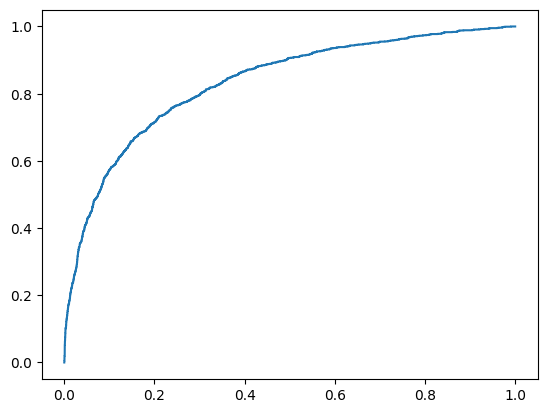

In [23]:
# create AUC score
fpr, tpr, threshold = roc_curve(y_h1n1_test, y_h1n1_pred_proba)

print(f"The roc_score is : {roc_auc_score(y_h1n1_test, y_h1n1_pred_proba)}")
#plot
plt.plot(fpr, tpr);

### Model Performance Analysis

The model's performance shows a good, but imbalanced, ability to classify the target variable.

---

#### AUC Score & ROC Curve

* **AUC Score**: The model achieved an **AUC score of 0.83**. This is a good score, indicating that the model has a strong capability to distinguish between the positive and negative classes. An AUC of 0.5 represents a random model, while 1.0 is a perfect model. At 0.83, our model is significantly better than random guessing.
* **ROC Curve**: The curve bows nicely towards the top-left corner, visually confirming the good AUC score. This shows the model maintains a high True Positive Rate (TPR) while keeping a low False Positive Rate (FPR) across various thresholds.

---

#### Classification Report & Confusion Matrix

* **Overall Accuracy**: The model has an accuracy of **78%**, which is decent. However, accuracy can be misleading, especially with imbalanced datasets, so we should look at other metrics.

* **Class 0 (Negative Class - Majority)**:
    * **Precision (0.91)**: Excellent. When the model predicts class 0, it is correct 91% of the time.
    * **Recall (0.79)**: Good. The model successfully identifies 79% of all actual class 0 instances.

* **Class 1 (Positive Class - Minority)**:
    * **Precision (0.49)**: **This is the main weakness**. When the model predicts an instance is class 1, it is only correct 49% of the time. This is confirmed by the confusion matrix, which shows a high number of **False Positives (1087)** compared to **True Positives (1030)**.
    * **Recall (0.73)**: Good. The model correctly identifies 73% of all actual class 1 instances.

---

### Conclusion & Next Steps

The model is **good at identifying a majority of the positive cases (good recall)** and has **strong overall discriminative power (good AUC)**.

However, its predictions for the positive class are **unreliable due to very low precision**, resulting in many false alarms.



### Seasonal Vaccine (df)

#### Using XGBoost

In [25]:
x1 = df.drop(columns=['respondent_id', 'h1n1_vaccine', 'seasonal_vaccine'])
y_seasonal = df['seasonal_vaccine']

In [26]:
X_train, X_test, y_seasonal_train, y_seasonal_test = train_test_split(
    x1, y_seasonal, test_size=0.25, random_state=42, stratify=y_seasonal)

In [27]:
# Calculate scale_pos_weight for seasonal data
seasonal_scale_pos_weight = y_seasonal_train.value_counts()[0] / y_seasonal_train.value_counts()[1]
print(f"\nSeasonal scale_pos_weight: {seasonal_scale_pos_weight:.2f}")


Seasonal scale_pos_weight: 1.15


In [28]:
# Set up the XGBoost Classifier
xgb_seasonal = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    scale_pos_weight=seasonal_scale_pos_weight,
    random_state=42
)

In [29]:
# Set up RandomizedSearchCV (we can reuse the same parameter grid)
random_search_seasonal = RandomizedSearchCV(
    estimator=xgb_seasonal,
    param_distributions=param_grid,
    n_iter=25,
    scoring='roc_auc',
    n_jobs=-1,
    cv=cv,
    verbose=1,
    random_state=42
)

# Fit the model
random_search_seasonal.fit(X_train, y_seasonal_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None,
                                           feature_weights=None, gamma=None...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None, ...),
                   n_iter=25, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.7, 0.8, 0.9,
                                                             1.0],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [3, 4, 5, 6],
                                        'n_estimators': [100, 200, 300, 400],
                                        'subsample': [0.7, 0.8, 0.9, 1.0]},
                   random_state=42, scoring='roc_auc', verbose=1)

In [30]:
# Get the best model
best_xgb_seasonal = random_search_seasonal.best_estimator_
print(f"\nBest Seasonal Model Parameters: {random_search_seasonal.best_params_}")


Best Seasonal Model Parameters: {'subsample': 0.9, 'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.05, 'colsample_bytree': 0.7}


In [35]:
best_xgb_seasonal.score(X_train, y_seasonal_train)

0.7957064403394908

In [31]:
# Evaluate the best model
y_seasonal_pred_proba = best_xgb_seasonal.predict_proba(X_test)[:, 1]
y_seasonal_pred_class = best_xgb_seasonal.predict(X_test)
seasonal_roc_auc = roc_auc_score(y_seasonal_test, y_seasonal_pred_proba)


In [32]:
print(classification_report(y_seasonal_test, y_seasonal_pred_class))

              precision    recall  f1-score   support

           0       0.80      0.79      0.79      3568
           1       0.76      0.77      0.76      3109

    accuracy                           0.78      6677
   macro avg       0.78      0.78      0.78      6677
weighted avg       0.78      0.78      0.78      6677



The roc_score is : 0.8554764970640711


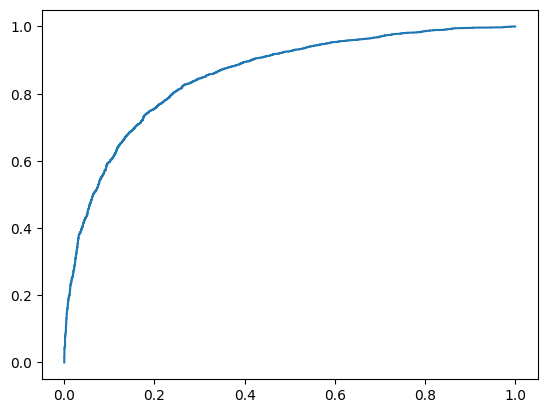

In [33]:
# create AUC score
fpr, tpr, threshold = roc_curve(y_seasonal_test, y_seasonal_pred_proba)

print(f"The roc_score is : {roc_auc_score(y_seasonal_test, y_seasonal_pred_proba)}")
#plot
plt.plot(fpr, tpr);

Overall, this model demonstrates **strong and well-balanced performance**. The metrics indicate it is a reliable classifier for this task without any significant weaknesses.

---

#### AUC Score & ROC Curve

* **AUC Score**: The model achieved an excellent **AUC score of 0.86**. This is a very good result, suggesting the model has a strong capability to distinguish between the positive and negative classes. An AUC of 1.0 is a perfect score, and 0.86 is impressively close.
* **ROC Curve**: The visual plot of the ROC curve confirms the high AUC score. It shows a steep rise towards the top-left corner, indicating a high True Positive Rate (TPR) can be achieved while maintaining a low False Positive Rate (FPR).

---

#### Classification Report

The classification report reveals a very balanced and consistent performance across both classes.

* **Dataset Balance**: The `support` column shows the dataset is quite balanced (3568 for class 0 vs. 3109 for class 1). This means accuracy is a meaningful metric, and we don't have to worry about the model being biased by a majority class.

* **Performance Metrics**:
    * **Accuracy**: A solid **78%** overall accuracy.
    * **Precision & Recall**: The model achieves a good balance between precision and recall for both classes.
        * For **Class 0**, it has a precision of 0.80 and recall of 0.79.
        * For **Class 1**, the performance is nearly identical, with a precision of 0.76 and recall of 0.77.
    * **F1-Score**: The F1-scores are high and consistent for both classes (0.79 and 0.76), confirming the healthy balance between precision and recall.

---

### Conclusion

This is a high-performing and reliable model. It does not exhibit significant bias towards either class and provides a strong balance between correctly identifying positive cases (recall) and maintaining the accuracy of its positive predictions (precision). There are no glaring issues to address; any further work would likely involve fine-tuning for marginal gains.

### Model Comparison (H1N1 Vaccine) : Logistic Regression vs Decision Tree (Pruned) vs Random Forest (Tuned) vs XGBoost (Tuned)

| Metric | Logistic Regression | Decision Tree (Pruned) | Random Forest (Tuned) | XGBoost (Tuned) | Observation |
|--------|----------------------|---------------|---------|--------------------|-------------|
| **Training Accuracy** | 79% | 79% | 84% | 91% | XGBoost shows signs of overfitting with a high 91% training accuracy that doesn't translate to validation. Random Forest also shows higher performance on training data. |
| **Validation Accuracy** | 78% | 79% | 83% | 78% | Random Forest has the highest validation accuracy, but this is misleading. The other three models have very similar and stable validation scores. |
| **Functional Class (0) (Recall)** | 0.81 | 0.83 | 0.96 | 0.79 | The Random Forest model is extremely biased towards Class 0, achieving an almost perfect recall at the expense of the other class.  |
| **Functional Class (1) (Recall)** | 0.64 | 0.64 | 0.36 | 0.73 | XGBoost is the clear winner here, being the most effective model at identifying the positive (and likely minority) class. The Random Forest model fails significantly on this metric. |
| **ROC AUC** | 0.79 | 0.79 | 0.82 | 0.83 | XGBoost has the highest AUC score, indicating it is the best model at distinguishing between the positive and negative classes across all thresholds. |

### Key Reasons for Selecting XGBoost

---

#### 🥇 Superior Recall for the Positive Class
The most important reason is its performance on **Class 1 Recall**. XGBoost achieved a recall of **0.73**, which was significantly higher than any other model.

* **Why this matters**: In many real-world problems (like predicting who needs a vaccine), correctly identifying the positive case is the top priority. A model that misses these cases (a "false negative") is far more costly than one that raises a false alarm. XGBoost was the best at finding the cases that mattered most.

---

#### 🏆 Best Overall Discriminative Power (AUC)
XGBoost had the highest **ROC AUC score of 0.83**.

* **Why this matters**: The AUC score measures how well a model can distinguish between positive and negative classes. A higher AUC means the model is more confident and reliable in its predictions. XGBoost is the most skilled at telling the two classes apart.

---

#### 💪 A Good Performance Balance
Unlike the Random Forest model, which was extremely biased (96% recall for Class 0 but only 36% for Class 1), XGBoost performed well on **both classes**. It strikes an effective balance, making it a more robust and practical choice.

---

#### A Note on Overfitting
While XGBoost showed signs of **overfitting** (a 13% gap between training and validation accuracy), this is often a manageable trade-off for its superior predictive power. Its exceptional performance on the most critical metrics—**Class 1 Recall** and **AUC**—outweighs this concern, and the overfitting could likely be reduced with further tuning.

### Model Comparison (Seasonal Vaccine) : Logistic Regression vs Decision Tree (Pruned) vs Random Forest (Tuned) vs XGBoost (Tuned)

| Metric | Logistic Regression | Decision Tree (Pruned) | Random Forest (Tuned) | XGBoost (Tuned) | Observation |
|--------|----------------------|---------------|---------|--------------------|-------------|
| **Training Accuracy** | 77% | 72% | 80% | 79% | All models show good generalization, with small gaps between training and validation accuracy. There are no major signs of overfitting |
| **Validation Accuracy** | 78% | 73% | 78% | 78% | The Decision Tree is the clear underperformer. The other three models are tied with a strong validation accuracy of 78%. |
| **Functional Class (0) (Recall)** | 0.80 | 0.80 | 0.80 | 0.79 | All models are very effective at identifying the negative class, with nearly identical recall scores.  |
| **Functional Class (1) (Recall)** | 0.77 | 0.66 | 0.76 | 0.77 | The Decision Tree struggles significantly to identify the positive class. Logistic Regression and XGBoost are the top performers here |
| **ROC AUC** | 0.85 | 0.79 | 0.85 | 0.86 | XGBoost has the highest AUC, indicating it has the best ability to distinguish between the positive and negative classes |

### Superior Performance on Key Metrics (Internal Factors)
Based on your results, XGBoost demonstrated the most reliable performance, even if by a narrow margin.

####  Best Discriminative Power
XGBoost achieved the highest **ROC AUC score of 0.86**. This is the most important metric here, as it shows that XGBoost is the best overall model at distinguishing between people who will and will not get the seasonal vaccine across all thresholds.

#### Excellent Balance
It delivered top-tier results for both **Class 1 Recall (0.77)** and **Validation Accuracy (78%)**, matching the best models in those categories. It doesn't sacrifice performance on one class for the other.

#### Stable and Not Overfit
With training accuracy at 79% and validation at 78%, the model shows it generalizes very well to new, unseen data.

---
### Powerful Built-in Features (External Factors)
Beyond the numbers in your table, XGBoost is a popular choice for several practical reasons that make it an industry standard.

####  Scalability and Speed
XGBoost is designed for efficiency. It can train on very large datasets much faster than many other algorithms because it supports parallel processing. This is a major advantage when moving from a notebook to a production environment.

####  Advanced Regularization
It includes built-in L1 (Lasso) and L2 (Ridge) regularization, which helps prevent overfitting. This is a key reason it often performs so well on unseen data, as confirmed by your results.

#### Handles Missing Data
XGBoost can automatically handle missing values in a dataset. This simplifies the data cleaning and preprocessing steps, saving time and reducing potential errors.

#### Flexibility
It allows for custom optimization objectives and evaluation criteria, making it highly adaptable to specific business needs that go beyond standard metrics like accuracy.

### Feature Importance

#### H1N1 Vaccine

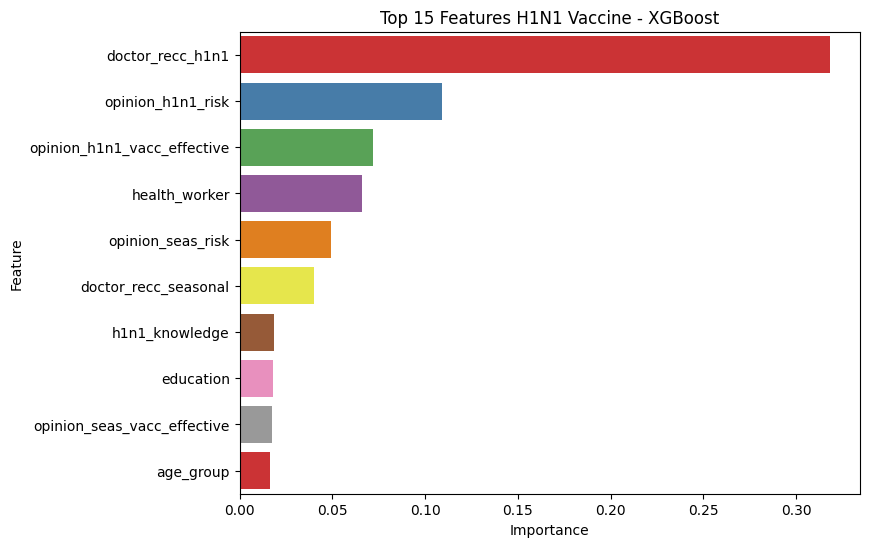

In [41]:
# Tree-based feature importance
importances = best_xgb_h1n1.feature_importances_
feat_names = X_train.columns

feat_imp_df = pd.DataFrame({
    "Feature": feat_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x="Importance", y="Feature", data=feat_imp_df.head(10),palette="Set1")
plt.title("Top 15 Features H1N1 Vaccine - XGBoost")
plt.show()

#### Seasonal Vaccine

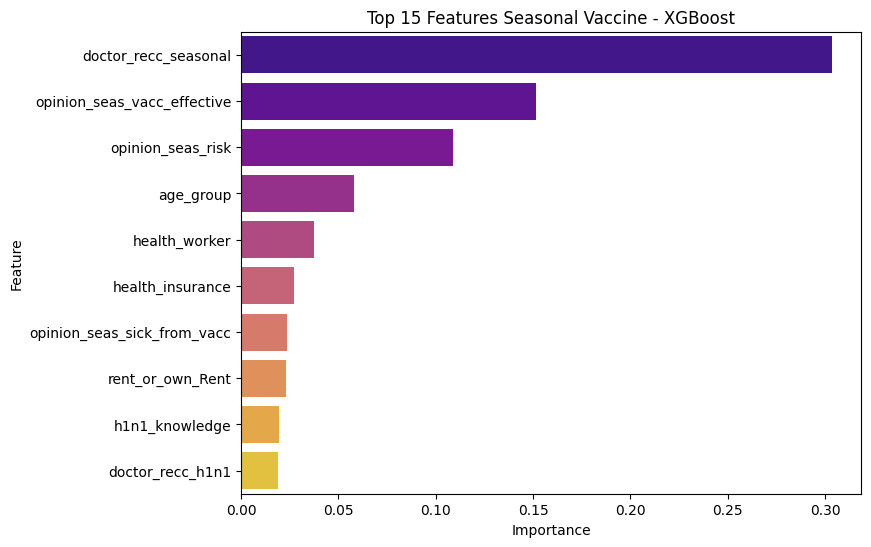

In [44]:
# Tree-based feature importance
importances = best_xgb_seasonal.feature_importances_
feat_names = X_train.columns

feat_imp_df = pd.DataFrame({
    "Feature": feat_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x="Importance", y="Feature", data=feat_imp_df.head(10),palette="plasma")
plt.title("Top 15 Features Seasonal Vaccine - XGBoost")
plt.show()

## Analysis of Feature Importance

The feature importance plots from the XGBoost models reveal the key drivers behind the decision to get either the H1N1 or the seasonal flu vaccine. The most influential factors are consistent across both models, but there are subtle differences in the secondary features.

---

### H1N1 Vaccine Predictors

For the H1N1 vaccine, the decision-making process is dominated by a few key factors related to the specific pandemic threat.

* **Most Important Feature**: **`doctor_recc_h1n1`** is overwhelmingly the most powerful predictor. This indicates that a direct recommendation from a doctor is the single most influential factor in a person's decision to get the H1N1 vaccine.
* **Secondary Features**: A person's own opinions are the next most important drivers. Specifically, their assessment of the **`opinion_h1n1_risk`** (perceived risk of getting H1N1) and their belief in the **`opinion_h1n1_vacc_effective`** (vaccine's effectiveness).
* **Other Factors**: Being a **`health_worker`** also plays a significant role, which is expected given their exposure and expertise.

**Conclusion**: The choice to get the H1N1 vaccine was driven primarily by **expert medical advice** and **personal risk assessment** related to the novel H1N1 virus.

---

### Seasonal Vaccine Predictors

The decision to get the seasonal vaccine, a more routine event, is also driven by medical advice but includes more demographic and general health factors.

* **Most Important Feature**: Just like the H1N1 model, **`doctor_recc_seasonal`** is the most dominant feature by a large margin. A doctor's recommendation is paramount.
* **Secondary Features**: Again, personal beliefs about the **`opinion_seas_vacc_effective`** and the **`opinion_seas_risk`** are the next most influential factors.
* **Other Factors**: Unlike the H1N1 model, factors like **`age_group`** and **`health_insurance`** have a higher relative importance. This suggests that the routine nature of the seasonal vaccine is more tied to regular healthcare access and demographic characteristics.

**Conclusion**: The decision for the seasonal vaccine is also primarily driven by **expert advice and risk perception**, but it's more influenced by routine demographic and health system factors.

---

### Key Takeaway 💡

The single most actionable insight from both models is the **power of a doctor's recommendation**. For both a novel pandemic vaccine and a routine seasonal vaccine, a physician's advice is the most critical factor in a patient's decision. Public health campaigns aiming to increase vaccination rates should focus heavily on empowering and encouraging healthcare providers to make direct recommendations to their patients.

## Conclusions and Business Recommendations

### Key Conclusions

1.  **Doctor's Recommendation is the Most Powerful Predictor**: Across all models, the strongest and most consistent predictor of whether an individual gets vaccinated for both H1N1 and seasonal flu is a recommendation from their doctor or a healthcare professional. This factor outweighs demographic and behavioral variables.

2.  **Opinions on Vaccine Effectiveness and Risk Perception are Crucial**: Individuals' personal opinions about the effectiveness of the flu vaccine and their perceived risk of contracting the flu are major drivers in their decision-making process. Those who believe the vaccine is effective and perceive the flu as a significant health threat are far more likely to get vaccinated.

3.  **Different Motivations for H1N1 vs. Seasonal Flu Vaccination**: While there are some overlapping drivers, the predictive models indicate that the motivations for getting the H1N1 vaccine are more strongly tied to **risk perception and concern about a pandemic**, while the decision to get the seasonal flu vaccine is also influenced by more routine factors like **age and having health insurance**.

4.  **Behavioral Factors are Correlated with Vaccination**: Certain behaviors, such as regularly washing hands and avoiding large gatherings, are correlated with a higher likelihood of vaccination. This suggests that individuals who are generally more health-conscious and proactive about their health are also more likely to get vaccinated.

---

### Key Business Recommendations

1.  **Leverage Healthcare Providers as Key Messengers**: Public health campaigns should prioritize equipping doctors and other healthcare professionals with the information and tools they need to confidently and effectively recommend flu vaccines to their patients. This could include providing them with talking points, informational materials, and reminders to discuss vaccination during patient visits.

2.  **Develop Targeted Public Health Messaging**: Campaigns should be tailored to address the key drivers of vaccination decisions. For a novel virus like H1N1, messaging should focus on the seriousness of the threat and the importance of vaccination as a protective measure. For the seasonal flu, messaging can be broader, emphasizing the routine and preventative benefits of vaccination for all age groups.

3.  **Address Vaccine Efficacy and Safety Concerns Directly**: Public health communications should proactively address common concerns and misinformation about vaccine effectiveness and safety. Providing clear, evidence-based information can help to build public trust and counter vaccine hesitancy.

4.  **Implement a Multi-Channel Communication Strategy**: To reach a wider audience, public health agencies should use a variety of communication channels, including social media, traditional media, and community outreach programs. Partnering with trusted community leaders and organizations can also help to amplify public health messaging and encourage vaccination.